In [12]:
import pandas as pd
import numpy as np

# Scikit-learn library
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import  DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

# Library for diagram visualization
from graphviz import Digraph

# **Outline**

- [**Data preparation**](#data-preparation)
- [**Decision Tree Theory**](#decision-tree)
    - [**Categorical Target Variable: Classification**](#categorical-target-variable-classification)
    - [**Continuous target Variable: Regression**](#continuous-target-variable-regression)
- [**Algorithm for Decision Tree Regressor**](#algorithm-for-decision-tree-regressor)
- [**Algorithm for Random Forest**](#algorithm-for-random-forest)

# **Data preparation**

Before starting the explanation about decision tree models, let's prepare the dataset that will be used. For this, I choose to work with a simple dataset for California Housing Prices from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices). The goal is to create a regression model for predicting housing prices by using decision tree and random forest.

- **Preparation:**
    - keep only the records where `ocean_proximity` is either `<1H OCEAN` or `INLAND`.
    - Fill missing values with zeros.
    - Apply the log transform to `median_house_value` to reduce outlier influence.
    - train/validation/test split with 60%/20%/20% distribution.
    - Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.


In [13]:
df = pd.read_csv("data/housing.csv")
#display(df.head(2))

# Keep only  '<1H OCEAN' and 'INLAND' from ocean_proximity
df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

# Fill missing values
#print('Missing values\n',df.isnull().sum()[4:5])
df.fillna(0, inplace = True) 

# Log transform to median_house_value
df['median_house_value'] = df['median_house_value'].agg(np.log1p)

# Train/Validation/Test split
df_train_large, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_train_large, train_size = 0.75, random_state = 1)

Y_train_large = df_train_large['median_house_value'].values
Y_test = df_test['median_house_value'].values
Y_train = df_train['median_house_value'].values
Y_val = df_val['median_house_value'].values

# Drop target variable from train, validation and test sets
df_train_large.drop('median_house_value', axis=1, inplace=True)
df_train.drop('median_house_value', axis=1, inplace=True)
df_val.drop('median_house_value', axis=1, inplace=True)
df_test.drop('median_house_value', axis=1, inplace=True)


# Convert DataFrames to dictionary records
train_dict = df_train.to_dict(orient='records')
train_large_dict = df_train_large.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')

dv = DictVectorizer(sparse=False)

# Fit and transform
X_train = dv.fit_transform(train_dict)
X_train_large = dv.transform(train_large_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

# **Decision Tree Theory**

Consider a hypothetical dataset with multiples numerical features $\mathbf{X}_{1},\cdots, \mathbf{X}_{d}$ and a target variable $\mathbf{Y}$. These features and the target variable are represented as column vectors in the dataset, as shown:

$$
\left( \begin{array}{c|ccc|c}
\text{Instance}    &\mathbf{X}_{1}&\cdots & \mathbf{X}_{d}  & \mathbf{Y}\\
\hline
\mathbf{x}_{1} & x_{11}& \cdots&x_{1d}&y_1 \\
\vdots&\vdots&\ddots&\vdots&\vdots\\
\mathbf{x}_{n}&x_{n1}&\cdots&x_{nd}&y_n
\end{array} \right).$$

In this representation, each row vector $ \mathbf{x}_i = ( x_{i1}, \ldots, x_{id})$ constitutes an instance of the dataset, with $d$ feature values. The index $i$ ranges from 1 to $n$, where $n$ is the total number of instances. The dataset can be further decomposed into a feature matrix $\mathbf{X}$ and a target vector $\mathbf{Y}$:

$$\mathbf{X}=
\left( \begin{array}{ccc}
  x_{11}& \cdots&x_{1d} \\
\vdots&\ddots&\vdots&\\
x_{n1}&\cdots&x_{nd}
\end{array} \right) ~~~ \text{and} ~~~ 

\mathbf{Y} = \left( \begin{array}{c}
y_1\\
\vdots\\
y_n
\end{array} \right)
$$

Here, the feature matrix $\mathbf{X}$ is composed of all feature vectors, while the target vector $\mathbf{Y}$ can take either discrete or continuous values, depending on the problem context. In the case of discrete values, each unique class in $\mathcal{Y}$ corresponds to a partition of the dataset, formed by grouping instances $\mathbf{x}_i$ with the same class. For continuous values, the target variable can represent a range of numerical outcomes.

A decision tree is a recursive model that employs partition-based methods to predict the class $\hat{y}_i$ for each instance $\mathbf{x}_i$. The process starts by splitting the dataset into two partitions. These partitions are further divided recursively, until a state is achieved in which the majority of instances  $\mathbf{x}_i$ within a partition belong to the same class.

One important partition-based method employed in most decision tree models, such as CART, is the axis-parallel hyperplane. This approach is commonly used in high-dimensional spaces represented by the dataset's features. The term "hyperplane" refers to the generalization of a geometric plane in a space with more than three dimensions.

The mathematical formulation for such a hyperplane is given by the condition:

$$h(\mathbf{x}) = \mathbf{x} \cdot \mathbf{w} + b\leq 0$$

Here, the $\mathbf{x}$ variable in this function $h(\mathbf{x})$ can be any instance from the dataset. The weight vector $\mathbf{w}$ is restricted a priori to one of the standard basis vectors $\{\mathbf{e}_1,\cdots,\mathbf{e}_j,\cdots \mathbf{e}_d\}$, where $\mathbf{e}_j$ has a value of 1 for the jth dimension and 0 for all other dimensions. This implies that the weights determine the orientation of the hyperplane in one of the basis vector directions, while the bias term translates it along that axis. The base vectors of a $d$-dimensional space are given by:

$$ 
\mathbf{e}_1 = \left( \begin{array}{c}
1\\
\vdots\\
0\\
\vdots\\
0
\end{array} \right),~
\mathbf{e}_i = \left( \begin{array}{c}
0\\
\vdots\\
1\\
\vdots\\
0
\end{array} \right),~~
\mathbf{e}_d = \left( \begin{array}{c}
0\\
\vdots\\
0\\
\vdots\\
1
\end{array} \right)
$$


On the other hand, the inequality $h(\mathbf{x}) \leq 0$ serves a particular purpose: it defines a half-space. Any instance $\mathbf{x}$ for which $h(\mathbf{x}) \leq 0$ lies on one side of the hyperplane, and any instance for which $h(\mathbf{x}) > 0$ lies on the other side. In this way, the hyperplane acts as a decision boundary that partitions the dataset into two partitions based on the sign of $h(\mathbf{x})$.

For a given standard basis vector chosen as the weight $\mathbf{w} = \mathbf{e}_j$, where $j$ can be an integer between 1 and $d$, the decision condition $h(\mathbf{x})$ for some instance $\mathbf{x}_i$ is represented by:

$$h(\mathbf{x}_i) = \mathbf{e}_j \cdot \mathbf{x}_i  + b \leq 0$$

which simplifies to:

$$x_{ij} \leq t$$

Here $t = -b$ represents a specific value within the domain of the feature vector $\mathbf{X}_j$.The split condition for the ith feature will be then the value of the jth element from the row vector $\mathbf{X}_j$. The optimal offset $b$ is chosen to minimize a particular criterion, such as a loss function, for the partitioned datasets.

For simplicity, let $\mathcal{D}$ denote the dataset, which also serves as a representation of the feature space for our discussion. Upon applying the decision boundary, the dataset $\mathcal{D}$ is divided into two mutually exclusive partitions: $\mathcal{D}_Y$ and $\mathcal{D}_N$. The partition $\mathcal{D}_Y$ includes instances that satisfy the inequality $x_{ij} \leq t$, while $\mathcal{D}_N$ includes those that do not. More formally, for each instance $\mathbf{x}_i$:

- If the $j$-th feature $x_{ij}$ value for the $i$-th instance satisfies the condition $x_{ij} \leq t$, then the instance is allocated to the set

  $$\mathcal{D}_Y = \{\mathbf{x}_i| x_{ij} \leq  t\}$$
  
  which grouped all instances $\mathbf{x}_i$ such that their $j$-th feature value $x_{ij}$ is less than or equal to the threshold $t$.

- Otherwise, the instance are allocated into the set

  $$\mathcal{D}_N = \{\mathbf{x}_i| x_{ij} >  t\ \}$$

In this context, $t$ is a pre-selected threshold that serves as the decision boundary that separates the two partitions


Given that $x_{ij}$ is a element from the feature vector $\mathbf{X}_j$, we can turn this more explicitly in the notation. To express this condition in a more generic form that represents the behavior across the entire feature, we can write the inequality $x_{ij} \leq t$ for all $i = 1, 2, \ldots, n$ as

$$\mathbf{X}_j \leq t$$

This generic form implicitly implies that the condition is applicable to each element $x_{ij}$, where $i = 1, 2, \ldots, n $ across the entire dataset $\mathcal{D}$. By using this generic representation, the rules becomes a general principle that applies not just to individual instances, but to the entire feature, providing a view on how the feature $\mathbf{X}_j$ contributes to the partitioning of $\mathcal{D}$.

**Particular case in two dimension**

To illuminate the partition-based methods used in the decision tree model, let's consider a hypothetical scenario involving a synthetically generated dataset. This dataset will have two features, $\mathbf{X}_1$ and $\mathbf{X}_2$, and a multi-class target variable $\mathbf{Y}$ with four possible classes. Mathematically the dataset can be represented as:

$$
\left( \begin{array}{c|cc|c}
\text{Instance}    &\mathbf{X}_{1}& \mathbf{X}_{2}  & \mathbf{Y}\\
\hline
\mathbf{x}_{1} & x_{11}&x_{12}&y_1 \\
\vdots&\vdots&\vdots&\vdots\\
\mathbf{x}_{n}&x_{n1}&x_{n2}&y_n
\end{array} \right).$$

where each instance will be randomly generated to be in one of the four possible classes of the feature vector $\mathbf{Y}$. Then two threshold values are selected to partition the dataset $\mathcal{D}$ into four distinct regions $\mathcal{D}_1$, $\mathcal{D}_2$  $\mathcal{D}_3$ and $\mathcal{D}_4$ .

<center><img src = "figures/axis_parallel.png" width="500" height="400"/></center>

By observing the plot, we can gain a visual intuition into how partition-based methods would partition the feature space to isolate instances of different classes.  Each region within this space is defined by a set of rules. These rules act as decision conditions, determining the region to which each instance belongs. When the model evaluates a given instance, it follows this set of decision rules:


- $\mathcal{D_1}$: If $\mathbf{X}_1 \leq 3.5$ and $\mathbf{X}_2 > 4.5$, then belongs to  class 4
- $\mathcal{D_2}$: If $\mathbf{X}_1 > 3.5$ and $\mathbf{X}_2 > 4.5$, then belongs to  class 2
- $\mathcal{D}_3$: If $\mathbf{X}_1 \leq 3.5$ and $\mathbf{X}_2 \leq 4.5$, then belongs to  class 1
- $\mathcal{D_4}$: If $\mathbf{X}_1 > 3.5$ and $\mathbf{X}_2 \leq 4.5$, then belongs to  class 3

After established the partitioning of our feature space into distinct regions, we can represent these partitions in a more structured form, using decision tree diagram, which gives the name of the model. A decision tree diagram will represent a series of decisions made on the features of the dataset to reach a conclusion about the class of an instance. 

To those decision rules, we can draw the following diagram which visually can give a interpretation of the decision-making process in classifying an instance based on its feature values. Consider the following diagram of a decision tree:

<center><img src = "figures/decision_tree_diagram.png" width="600" height="400"/></center>

Each node in the decision tree represents a decision criterion based on a feature's threshold, and each branch represents the outcome of the test. The leaves of the tree represent the final classes or regions, $\mathcal{D_1}, \mathcal{D_2}, \mathcal{D_3}$, and $\mathcal{D_4}$. By the diagram of the tree, we have

- The **red** node, which is the root, with the initial question about the feature's threshold.
- The **blue** nodes are the decision nodes that further refine the classification by adding more conditions and creating the branch.
- The **green** nodes are the leaves of the tree, which is the final stage where each regions has a majority of one class.

## **Categorical Target Variable: Classification**

**Metrics Evaluation for classification**

In classification, our task is to classify instances by their classes from the target variable $\mathbf{Y}$. A important step in this process is evaluating how well a partition in the feature space distinguishes between these classes. To evaluate the quality of a partition in the feature space, we need a metric evaluation to select an optimal split point. But before entering into the evaluation metrics, it's necessary to understand how probabilities are associated with the chances of an instance being allocated in one partition or another. These probabilities will provide the basis for measuring the class distribution within a partition, which in turn influences the quality of the split.

When we have numerical features, one possible strategy is to consider only the midpoints between two successive and distinct values of a given feature $\mathbf{X}_j$. These midpoints can be denoted as ${t_1, \cdots, t_m}$, such that $t_1 < \cdots < t_m$. Each split point $\mathbf{X}_j\leq t$ necessitates the definition of a probability mass function (PMF). In the context of decision trees, a PMF will be a function that provides the probabilities of discrete classes occurring within a given partition.

The probability mass function for a split point $\mathbf{X}_j\leq t$ is:

$$p(c_i|\mathcal{D}_Y) = p(c_i|\mathbf{X}_j \leq t) $$

$$p(c_i|\mathcal{D}_N) = p(c_i|\mathbf{X}_j > t)$$

Here, $c_i$ is one of the classes $\{c_1, \cdots, c_k \}$ from the target vector $\mathbf{Y}$. These PMFs account for the distribution of each class $c_i$ in the partitions $\mathcal{D}_Y$ and $\mathcal{D}_N$. In this formulation, $p(c_i|\mathbf{X}_j \leq t)$ represents the probability of class $c_i$ being in partition $\mathcal{D}_Y$, and similarly $p(c_i|\mathbf{X}_j > t)$ for partition $\mathcal{D}_N$.

The utility of these PMFs is to quantify the idea of "purity" for each partition with respect to the distribution of target classes. A partition is considered "pure" if it contains instances predominantly from a single class, therefore yielding a higher probability for that class in the corresponding PMF.

**Metrics**

Evaluating the quality of split points is an important step for optimizing the performance of a decision tree. Different metrics offer various ways to measure the "purity" of the partitions created by each split.

- **Information Gain**

    Information gain measures the reduction of disorder or uncertainty in a system. The goal is to use entropy as a metric for each partition, favoring a lower entropy if the partition is pure (i.e., most instances have the same class label). On the other hand, if class labels are mixed with no majority class, a partition has higher entropy.

    The entropy of a set of dataset $\mathcal{D}$ is defined as:

    $$H(\mathcal{D}) = - \sum^{k}_{i=1} p(c_i| \mathcal{D}) \log{p(c_i| \mathcal{D})}$$

    where $p(c_i| \mathcal{D})$ is the probability of class $c_i$ in $\mathcal{D}$, and $k$ is the number of different classes from the target vector $\mathbf{Y}$.

    When a split  point $\mathbf{X}_j\leq t$ partitions $\mathcal{D}$ into $\mathcal{D}_Y = \{\mathbf{x}_i| x_{ij} \leq  t\}$ and $\mathcal{D}_N = \{\mathbf{x}_i| x_{ij} >  t\ \}$, we define the split entropy as the weighted entropy of each of the resulting partitions:

    $$H(\mathcal{D}_Y, \mathcal{D}_N) = \frac{n_Y}{n}H(\mathcal{D}_Y) + \frac{n_N}{n}H(\mathcal{D}_N)$$

    where $n = |\mathcal{D}|$ is the number of instances in $\mathcal{D}$, and $n_Y = |\mathcal{D}_Y|$ and $n_N = |\mathcal{D}_N|$ are the number of points in $\mathcal{D}_Y$ and $\mathcal{D}_N$, respectively.

    The information gain for a given split point, representing the reduction in overall entropy, is defined as:

    $$\text{Gain}(\mathcal{D},\mathcal{D}_Y, \mathcal{D}_N) = H(\mathcal{D}) - H(\mathcal{D}_Y, \mathcal{D}_N)$$

    A higher information gain corresponds to a greater reduction in entropy, thus representing a better split point. Therefore, we can score each split point and select the one that provides the highest information gain.


- **Gini Index**

    The Gini index, another common purity measure for a split point, is defined as:

    $$G(\mathcal{D}) = 1 - \sum_{i=1}^{k} p(c_i| \mathcal{D})^2$$

    A higher Gini index value implies less purity or more mixed classes within the partition, while lower values indicate higher purity with respect to the classes. The weighted Gini index of a split point is then defined as:

    $$G(\mathcal{D}_Y, \mathcal{D}_N) = \frac{n_Y}{n}G(\mathcal{D}_Y) + \frac{n_N}{n}G(\mathcal{D}_N)$$


- **CART**

    Another useful measure is the CART, defined as:

    $$\text{CART}(\mathcal{D}_Y, \mathcal{D}_N) = 2 \frac{n_Y}{n}\frac{n_N}{n} \sum_{i = 1}^k \big[p(c_i| \mathcal{D}_Y )  -p(c_i| \mathcal{D}_N)\big]$$

    This metric maximizes the difference between the class PMF for the two partitions; a higher CART value implies a better split point.

## **Continuous Target Variable: Regression**

**Metrics Evaluation for Regression**

In regression, our task is to predict a continuous target variable $\mathbf{Y}$. When selecting a split point, instead of calculating probabilities over discrete classes, the mean of the target $\mathbf{Y}$  is calculated for  instances within a given partition. Consequently, each partition is labeled by the mean values of the target variable.


Given a feature $\mathbf{X}_j$ and potential split point $t$, the dataset is divided as follows:

- If the feature satisfies the condition $\mathbf{X}_j \leq t$, the instance is allocated to the set:

    $$
    \mathcal{D}_Y = \{ \mathbf{x}_i | \mathbf{X}_j \leq t \}
    $$

    Here, $\mathcal{D}_Y$ aggregates all instances $\mathbf{x}_i$ for which their $j$-th feature $\mathbf{X}_j$ is less than or equal to the threshold $t$. 

- Otherwise, the instance is allocated to the set
    $$
      \mathcal{D}_N = \{ \mathbf{x}_i | \mathbf{X}_j  > t \}
    $$

In both cases, the partitions $\mathcal{D}_Y$ and $\mathcal{D}_N$ are labeled by the mean values of $\mathbf{Y}$ within them. We can calculate the mean of each partition as 

$$\mu(\mathcal{D}_Y) = \mu_Y = \frac{\sum_{i \in \mathcal{D}_Y} y_i}{n_Y},~~~\mu(\mathcal{D}_N)= \mu_N = \frac{\sum_{i \in \mathcal{D}_N} y_i}{n_N}$$

where $n_Y = |\mathcal{D}_Y|$ and $n_N = |\mathcal{D}_N|$ are are the total number of instances in each set, respectively.

After partitioning the dataset into $\mathcal{D}_Y$ and $\mathcal{D}_N$, we need a metric for selecting the best split point in regression trees. 

**Reduction in Variance**

The Reduction in Variance metric calculates the decrease in the variance of the target variable $\mathbf{Y}$ as a result of the split. A **higher reduction in variance** means a more "informative" split, leading to subsets that are more homogeneous in terms of the target variable. This is achieved by minimizing the variance within each new partition. Mathematically, the variance of each partition is given by:


$$\sigma^2(\mathcal{D}_Y) = \sigma^2_Y=\frac{1}{n_Y} \sum_{i \in \mathcal{D}_Y} (y_i - \mu_Y)^2 ~~~\sigma^2(\mathcal{D}_N) =\sigma^2_N= \frac{1}{n_N} \sum_{i \in \mathcal{D}_N} (y_i - \mu_N)^2$$

The formula for Reduction in Variance, used to compare the variance in the entire dataset $\mathcal{D}$ with the variances $\sigma^2_Y$ and $\sigma^2_N$ in the partitions, is given by:


$$\Delta \sigma^2 = \sigma^2(\mathcal{D}) - \left( \frac{n_Y}{n} \sigma^2(\mathcal{D}_Y) + \frac{n_N}{n} \sigma^2(\mathcal{D}_N) \right)$$


The objective is to **maximize this reduction** when choosing the best split, which implies minimizing the variance within each new partition.


# **Algorithm for Decision Tree Regressor**  

In [14]:
class Node():

    def __init__(self, feature_index=None, threshold=None, 
                 left_node=None, right_node=None, 
                 var_reduction=None, leaf_value=None, 
                 node_value = None, samples=0):
        
        self.feature_index = feature_index
        self.threshold = threshold  
        # Left and right nodes
        self.left_node = left_node
        self.right_node = right_node
        self.var_reduction = var_reduction
        self.node_value = node_value 
        # leaf node
        self.leaf_value = leaf_value
        self.samples = samples


    @property
    def is_leaf(self):
        return self.leaf_value is not None

In [15]:
class MyDecisionTreeRegressor():
    def __init__(self, min_samples_split = 2, max_depth = 2):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def fit(self, X, Y):
        dataset = np.concatenate((X, Y.reshape(-1, 1)), axis=1)
        self.root = self._grow_tree(dataset)

    def _grow_tree(self, dataset, current_depth = 1):
        # Recursive function
        X, Y = dataset[:,:-1], dataset[:,-1]
        n_samples, n_features = X.shape

        if (self.max_depth is not None) and (current_depth > self.max_depth):
                    return Node(leaf_value=self.compute_node(Y),
                                 samples=n_samples, node_value=self.compute_node(Y))

        if n_samples >= self.min_samples_split:
            best_split = self._best_split(X, Y, n_features)
            
            if (best_split['variance_reduction'] > 0):
        
                right_subtree = self._grow_tree(best_split['dataset_right'], 
                                          current_depth + 1)
                

                left_subtree = self._grow_tree(best_split['dataset_left'], 
                                         current_depth + 1)
            
                node = Node(best_split['feature_index'], best_split['threshold'], 
                    left_subtree, right_subtree, best_split['variance_reduction'],
                    samples=n_samples, node_value = self.compute_node(Y)) 


                return  node   
             
        # leaf node
        return Node(leaf_value=self.compute_node(Y), samples=n_samples, 
                    node_value = self.compute_node(Y))
        
        
    def _best_split( self, X, Y, n_features):

        best_split = {
        "feature_index": None,
        "threshold": None,
        "dataset_left": None,
        "dataset_right": None,
        "variance_reduction": -float("inf")
        }

        # loop over all features
        for feature_index in range(n_features):
            # Get feature values of all instances
            feature_vector = X[:, feature_index]
            
            # if feature is categorical on-hot encoded
            #if set(np.unique(feature_vector)).issubset({0, 1}):
            #    thresholds = np.unique(feature_vector)
            # if feature is numerical
            #else:
            sort_features = np.sort(np.unique(feature_vector))
            thresholds = (sort_features[:-1] + sort_features[1:]) / 2

            # loop over all midpoints and get the best one
            for threshold in thresholds:
                # Split dataset into two partitions
                dataset_left, dataset_right = self._splitter(X, Y, feature_index, threshold)
            
                # check if partitions are not empty
                if (len(dataset_left) > 0 and len(dataset_right) > 0):
                    # Get target values of partitions
                    Y_left, Y_right = dataset_left[:,-1], dataset_right[:,-1]
                    # Calculate variance reduction
                    current_reduction = self.variance_reduction(Y, Y_left, Y_right)

                    # if the current reduction is better, update the best split 
                    if current_reduction >  best_split["variance_reduction"] :
                        
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["variance_reduction"] = current_reduction

        return best_split
    
    def _splitter(self, X, Y, feature_index, threshold):

        dataset = np.concatenate((X, Y.reshape(-1, 1)), axis=1)

        left_indices = np.argwhere(dataset[:, feature_index] <= threshold).flatten()
        right_indices = np.argwhere(dataset[:, feature_index] > threshold).flatten()
        
        dataset_left = dataset[left_indices]
        dataset_right = dataset[right_indices]
    
        return dataset_left, dataset_right

    def variance_reduction(self, Y, Y_left, Y_right):

        # Variance of parent and child left/right nodes
        varY = np.var(Y)
        varY_left = np.var(Y_left)
        varY_right = np.var(Y_right)

        # weights of child nodes
        n, nl, nr = len(Y), len(Y_left), len(Y_right)
        w_left = nl / n
        w_right = nr / n

        return varY - (w_left * varY_left + w_right * varY_right)
    
    def compute_node(self, Y):
        # Get mean of target values
        return np.mean(Y)
    

    def predict(self, X):
        Y_pred = np.array([self._search_tree(instance, self.root) for instance in X])
        return Y_pred

    def _search_tree(self, instance, node):
        # Recursive function
        if node.is_leaf:
            return node.leaf_value
        
        # check if instance value is less than node threshold
        if instance[node.feature_index] <= node.threshold:
            return self._search_tree(instance, node.left_node)
        
        else:  
            return self._search_tree(instance, node.right_node)
        
    def print_tree(self, node=None, indent=" "):
        ''' function to print the tree '''

        if node is None:
            node = self.root

        # Check for leaf nodes
        if node.is_leaf:
            print(indent, "Leaf Value:", node.leaf_value)
            print(indent, "Samples:", node.samples)
            return

        # Print information about this node: feature index, threshold, and variance reduction
        print(indent, "Feature X_" + str(node.feature_index))
        print(indent, "Threshold:", node.threshold)
        print(indent, "Variance Reduction:", node.var_reduction)
        print(indent, "Samples:", node.samples)

        # Print the left subtree
        print(indent, "Left:")
        self.print_tree(node.left_node, indent + "  ")

        # Print the right subtree
        print(indent, "Right:")
        self.print_tree(node.right_node, indent + "  ")

In [16]:
class DecisionTreeVisualizer:
    def __init__(self, decision_tree, feature_names):
        self.feature_names = feature_names
        self.decision_tree = decision_tree
        self.dot = Digraph(comment='Decision Tree')
        self.node_counter = 0

    def add_nodes_edges(self, node, parent_id=None, label=""):
        node_id = str(self.node_counter)
        self.node_counter += 1
        
        samples = getattr(node, "samples", 0)        
        # Display relevant information in the nodes
        if node.is_leaf:
            display_label = (f'Leaf\n'
                             f'Samples: {samples}\n'
                             f'Value: {node.leaf_value:.2f}')
        else:
            display_label = (f'{self.feature_names[node.feature_index]} ≤ {node.threshold:.3f}\n'
                             f'Samples: {samples}\n' 
                             f'Value: {node.node_value:.2f}')
        
        self.dot.node(node_id, label=display_label)

        if parent_id is not None:
            self.dot.edge(parent_id, node_id, label=label)

        if not node.is_leaf:
            self.add_nodes_edges(node.left_node, node_id, 'Yes')
            self.add_nodes_edges(node.right_node, node_id, 'No')

    def visualize_tree(self):
        self.add_nodes_edges(self.decision_tree.root)
        return self.dot

**Example 1**

Let's train a decision tree regressor using the scikit-learn library and the algorithm that we created in python to predict the `median_house_value` variable to compare both results. Let's train the models with `max_depth=1`. Which feature is used for splitting the data? The feature used to split the data is the same in both models?


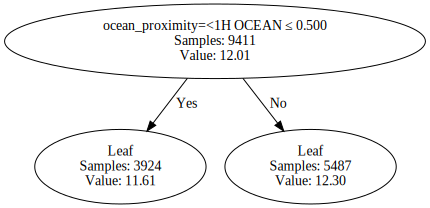

rmse 0.454424874819611


In [17]:
# My Model
mytree = MyDecisionTreeRegressor(max_depth = 1)
mytree.fit(X_train, Y_train)
Y_pred = mytree.predict(X_test)

feature_names=dv.feature_names_
visualizer = DecisionTreeVisualizer(mytree, feature_names = dv.feature_names_)
graph = visualizer.visualize_tree()
display(graph)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print('rmse', rmse)

# Running Time : 5.8 s

rmse 0.4544248748196092


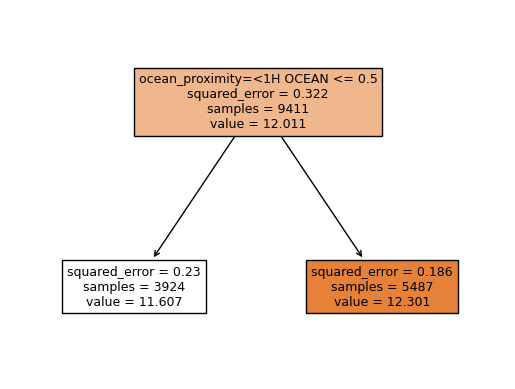

In [18]:
# scikit-learn Model
tree = DecisionTreeRegressor(max_depth = 1)
tree.fit(X_train, Y_train)
Y_pred = tree.predict(X_test)

feature_names=dv.feature_names_
plot_tree(tree, feature_names = dv.feature_names_, filled=True)

rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print('rmse', rmse)

# Running Time : 0.1 s

# **Algorithm for Random Forest**


A central characteristic of decision tree models is their instability. A minor perturbation in the training dataset can significantly affect the construction of the tree, thereby altering its predictions or decision boundaries. This kind of instability is often observed in systems sensitive to initial conditions, a concept that we can make a parallel in chaos theory. In chaos theory, those systems are central and show dynamic behaviors that are highly dependent on their starting conditions, often referred to as the "butterfly effect"

This sensitivity is clearly manifested in decision trees. The decisions made at the root node will influence the overall tree structure. A single anomalous instance, like an instance with NaN values or zeros, can drastically influence these initial decisions, leading to a different pattern and predictions. To mitigate this issue, the Random Forest algorithm was introduced.

The Random Forest algorithm is an ensemble learning method utilized for both classification and regression tasks. A random forest is simply an ensemble of $k$ decision trees, where each tree is constructed from a slightly perturbed dataset. These datasets are created through bootstrapping, a technique that resamples the original dataset with replacement. Furthermore, each tree is built by sampling a random subset of features at each internal node during the decision tree's construction.

The random sampling of features aims to introduce diversity among the trees,  therefore reducing their correlation and improving the ensemble's generalization. By averaging the predictions from the individual trees, the ensemble model more effectively captures the variations in the data, resulting in a more stable and accurate predictive model.

In [19]:
class MyRandomForestRegressor():
    def __init__(self,  n_estimators= 5, min_samples_split = 2,
                  max_depth = None, random_state = 1):
        self.n_estimators = n_estimators
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.trees = []
        np.random.seed(random_state)

    def fit(self, X, Y):
        for _ in range(self.n_estimators):
            
            bootstrap_X, bootstrap_Y = self._bootstrap(X, Y)
            tree = MyDecisionTreeRegressor(min_samples_split=self.min_samples_split,
                                           max_depth=self.max_depth)
            tree.fit(bootstrap_X, bootstrap_Y)
            self.trees.append(tree)

    def _bootstrap(self, X, Y):
        n_samples = X.shape[0]
        # Create a bootstrap sample
        indices = np.random.choice(n_samples, size= n_samples, replace=True, )
        return X[indices], Y[indices]

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(predictions, axis=0)

**Example 2**

Now let's compare both models for the random forest using the following parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (to make training faster)


What's the RMSE on validation? How close are the result of both models?

In [20]:
# My Model
rf = MyRandomForestRegressor(n_estimators = 10, random_state = 1)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_val)

rmse = np.sqrt(mean_squared_error(Y_val, Y_pred))
print('rmse = ', rmse)
# Running Time :6m 25s

rmse =  0.24526091708215395


In [21]:
# scikit-learn Model
rf = RandomForestRegressor(n_estimators = 10, random_state =1,  n_jobs=-1)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(Y_val, Y_pred))
print('rmse = ', rmse)
# Running Time : 0.1s

rmse =  0.244910835217013


# References

- [Zaki, M. J., & Meira Jr, W. (2020). Data mining and machine learning: fundamental concepts and algorithms. Cambridge University Press.](https://books.google.com/books/about/Data_Mining_and_Machine_Learning.html?id=oafDDwAAQBAJ&printsec=frontcover&source=kp_read_button&hl=en&newbks=1&newbks_redir=1)